# HW 10 CLUSTERING BUSINESS

*using Dr. Bianco's instructions as template*

Census Business data:
download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/


    $ for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

    $ for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

    $ for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done


NYC zip codes shape file is here: http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981


you may need to clean your data: for some NYC zip codes there may be no info
    
sanity check: you should have 20 (Ntimestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

IMPORTANT: we talked about the importance of "whitening" your data: dividing each feature by its standard deviation. 
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

## 1. Prepping data

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pylab as pl
import json
import zipfile as zf
from sklearn.cluster import KMeans, SpectralClustering, Birch, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

%pylab inline
np.random.seed(151214)

Populating the interactive namespace from numpy and matplotlib


The data will be loaded into a 3-D pandas Panel.

In [2]:
cols = ['zip', 'emp', 'qp1', 'ap', 'est']
df={}
for i in range(1994, 2014):
    fname = 'zbp{:02}totals.zip'.format(i%100)
    print i, 
    z = zf.ZipFile(fname)
    try:
        df[i] = pd.read_csv(z.open(fname.replace('.zip','.txt')), 
                         usecols=cols, dtype={'zip': 'str'})
    except ValueError:
        df[i] = pd.read_csv(z.open(fname.replace('.zip','.txt')), 
                         usecols=[x.upper() for x in cols], 
                         dtype={'ZIP': 'str'})
        df[i].rename(columns=dict(zip([x.upper() for x in cols], cols)),
                     inplace=True)

    #THE ORDER OF THESE TWO STATEMENTS MATTERS!
    #There's a duplicated row for zip 37892 in the 1995 
    #data set that caused the panel creation to fail
    df[i].drop_duplicates(subset='zip', inplace=True)  

    #Can't seem to cast type on an index_col, 
    #so need to do this step separately, AFTER drop_duplicates!
    df[i].set_index('zip', inplace=True)
    
    print df[i].shape, 

1994 (39259, 4) 1995 (39931, 4) 1996 (40099, 4) 1997 (40248, 4) 1998 (39467, 4) 1999 (39761, 4) 2000 (39853, 4) 2001 (39817, 4) 2002 (39451, 4) 2003 (39423, 4) 2004 (39583, 4) 2005 (39625, 4) 2006 (39657, 4) 2007 (39652, 4) 2008 (39240, 4) 2009 (39174, 4) 2010 (39104, 4) 2011 (39032, 4) 2012 (38818, 4) 2013 (38804, 4)


In [3]:
bizdata = pd.Panel.from_dict(df, orient='minor')

In [4]:
bizdata

<class 'pandas.core.panel.Panel'>
Dimensions: 4 (items) x 42652 (major_axis) x 20 (minor_axis)
Items axis: emp to est
Major_axis axis: 00501 to 99999
Minor_axis axis: 1994 to 2013

In [5]:
del df    #free up memory

Now we will load the geometry:

In [6]:
zipshape = json.loads(open('nyc-zip-code-tabulation-areas-polygons.geojson').read())
zipshapes = gpd.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')

In [7]:
print len(zipshapes.postalCode)
zips = list(set(zipshapes.postalCode))
print len(zips)

262
247


There are multiple shapes for some zips, so we `list(set())` them to get the unique values.

In [8]:
zipshapes.set_index('postalCode', inplace=True)

Now we need to parse the data frames in the panel. Besides the recorded values, there are also zeros and NaNs. The NaNs indicate that there was no record for the zip code in the given year and data set. The zeros indicate either an actual value of zero (which appears to be very rare in the data) or data that has been censored.

In [9]:
#bizdata['emp'].head(3)

We first want to address the zeros. Pandas has useful functions for dealing with NaNs, so first we move NaNs to a dummy value (here, -1) so that we can move the zeros to NaNs:

In [10]:
bizdata.fillna(-1, inplace=True)

In [11]:
#bizdata['emp'].head(3)

Now we can replace the zeros:

In [12]:
bizdata.replace(0, np.nan, inplace=True)

In [13]:
#bizdata['emp'].head(3)

We assume all zeros are censored values. When this occurs sporadically in the data, we can make a linear interpolation between the existing values; this is a more reasonable treatment than having the time series drop to zero and create a false event in the data. We use the interpolate function to fill in over the NaNs. We limit the number of NaNs over which to interpolate to 2 since we only have 19 intervals over which to characterize the time series; any more than 2 risks creating too many linear trends in the data. This leaves the remaining values as NaN.

In [14]:
for item, frame in bizdata.iteritems():
    #print item, type(bizdata[item]), type(frame)
    bizdata[item] = frame.interpolate(axis = 1, limit=2) #, inplace=True)

In [15]:
#bizdata['emp'].head(3)

Now move the dummy values back to NaN:

In [16]:
bizdata.replace(-1, np.nan, inplace=True)

In [17]:
#bizdata['emp'].head(3)

Now we need to determine what to do about NaN. These represent missing values and leftover zeros from the interpolation procedure described above. In order to have reasonable data to classify on, we need to pick a threshold number of points we must have in order to keep it in the analysis. Here I pick 15 (or 75% of the years in the study) and drop anything that does not meet this criterion. Then we use ffill to repeat the last known value when known, then bfill to repeat the first known value when the series begins with NaNs. Note that this is loaded into a dictionary of data frames since the four data sets will have different records meeting the criteria, so we cannot simply drop the series in the Panel.

In [18]:
bizframe={}
for item, frame in bizdata.iteritems():
    bizframe[item] = frame[frame.count(axis=1)>=15]
    frame.ffill(axis=1, inplace=True)
    frame.bfill(axis=1, inplace=True)

In [19]:
for k, v in bizframe.iteritems(): 
    print k, v.shape

ap (33436, 20)
qp1 (33306, 20)
emp (33213, 20)
est (38182, 20)


Now we reconstruct the Panel:

In [20]:
bizdata = pd.Panel.from_dict(bizframe)

In [21]:
#bizdata['emp'].head(3)

When we reconstruct the Panel, records missing in one set but present in another will show up in the missing set as 20 NaNs; we address this later on.

In [24]:
bizdata['emp'].head(3)

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
00501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01001,6198,5920,6130,6900,7121,7786,8042,8522,8485,8448,8650,9107,9564,9663,9681,9950,9185,8788,9033,9418
01002,6073,6153,6441,6328,6278,6607,6547,6955,6866,6771,6827,6691,6977,12635,13152,13729,15633,15878,16422,17263


Now let's take only the slice of the data corresponding to the list of zip codes created earlier:

In [25]:
idx = pd.IndexSlice
nycbiz = bizdata.loc[idx[:,zips,:]]

Now we normalize the time series by row:

In [26]:
rownorm = lambda row: (row-row.mean())/row.std()

In [27]:
nycbiz_norm = nycbiz.copy()
for itm, frm in nycbiz_norm.iteritems():
    nycbiz_norm[itm] = frm.apply(rownorm, axis=1)

In [28]:
nycbiz_norm

<class 'pandas.core.panel.Panel'>
Dimensions: 4 (items) x 247 (major_axis) x 20 (minor_axis)
Items axis: ap to qp1
Major_axis axis: 10122 to 11224
Minor_axis axis: 1994 to 2013

We break out each of the frames of the panel and only take the rows that have no NaNs:

In [29]:
nycbiz_emp = nycbiz_norm['emp'][nycbiz_norm['emp'].count(axis=1)==20]
nycbiz_est = nycbiz_norm['est'][nycbiz_norm['est'].count(axis=1)==20]
nycbiz_qp1 = nycbiz_norm['qp1'][nycbiz_norm['qp1'].count(axis=1)==20]
nycbiz_ap = nycbiz_norm['ap'][nycbiz_norm['ap'].count(axis=1)==20]

## 2. Clustering using KMeans; 3. Cluster centers

We lay the groundwork for multiple algorithms here. Since the cluster count is subjective, we show results of creating between $k=2$ and $k=8$ clusters. The function below creates the graphs and returns the array of cluster labels. Cluster centers are also plotted for KMeans (linewidth $ \propto \sqrt{n}$, with $n$ the number of series in each cluster).

In [30]:
colorlist = ['red','pink','orange','brown','green','blue','purple','gray']

In [31]:
def plotMultiCluster(data, algo='KMeans', maxK=8):
    k = {}
    kluster = {}

    print 'Creating families of 2 to {} clusters using {}...\nk ='.format(maxK, algo),
    for i in range(2,maxK+1):
        print i,
        if algo=='KMeans':
            k[i] = KMeans(n_clusters=i)
        elif algo=='spectral':
            k[i] = SpectralClustering(n_clusters=i)
        elif algo=='birch':
            k[i] = Birch(n_clusters=i)
        elif algo=='ward':
            # code from sklearn documentation: 
            # connectivity matrix for structured Ward
            connectivity = kneighbors_graph(data, n_neighbors=10, include_self=False)
            # make connectivity symmetric
            connectivity = 0.5 * (connectivity + connectivity.T)
            k[i] = AgglomerativeClustering(n_clusters=i, linkage='ward',
                                           connectivity=connectivity)
        else:
            raise NameError('Unsupported algorithm!')
        kluster[i] = k[i].fit(data)

    fig, ax = pl.subplots(maxK+1,maxK-1, figsize=(15,15))
    
    print '\nPlotting clusters...\nk =',
    for k in kluster.iterkeys():
        print k,
        ax[0, k-2].text(.5, .2, '$k={}$'.format(k), 
                        horizontalalignment='center', 
                        verticalalignment='center',
                        size=20,
                        transform=ax[0,k-2].transAxes)
        ax[0, k-2].set_frame_on(False)
        ax[0, k-2].axes.get_xaxis().set_visible(False)
        ax[0, k-2].axes.get_yaxis().set_visible(False)
        for i in range(len(data)):
            lab = kluster[k].labels_[i]
            ax[lab+1,k-2].plot(data.columns, data.iloc[i], 
                             c = colorlist[lab], 
                             alpha=.2)
        for c in range(k):
            n_k = len(kluster[k].labels_[kluster[k].labels_==c])
            ax[c+1,k-2].text(.97, .97, 
                           '$n={}$'.format(n_k),
                           horizontalalignment='right', 
                           verticalalignment='top',
                           size=12,
                           transform=ax[c+1,k-2].transAxes)
            if hasattr(kluster[k], 'cluster_centers_'):
                ax[c+1,k-2].plot(data.columns, kluster[k].cluster_centers_[c], 
                               c = 'black', 
                               linewidth=np.sqrt(n_k/2))
        for i in range(k,maxK):
            ax[i+1,k-2].set_frame_on(False)
            ax[i+1,k-2].axes.get_xaxis().set_visible(False)
            ax[i+1,k-2].axes.get_yaxis().set_visible(False)
            
    for i in range(maxK+1):
        for j in range(maxK-1):
            ax[i,j].set_xlim(min(data.columns),max(data.columns))
    
    klusters = pd.DataFrame(np.array([kluster[i].labels_ for i in range(2,maxK+1)]).T, 
                            data.index,
                            columns=['k{}'.format(i) for i in range (2,maxK+1)])
    return klusters

Creating families of 2 to 8 clusters using KMeans...
k = 2 3 4 5 6 7 8 
Plotting clusters...
k = 2 3 4 5 6 7 8


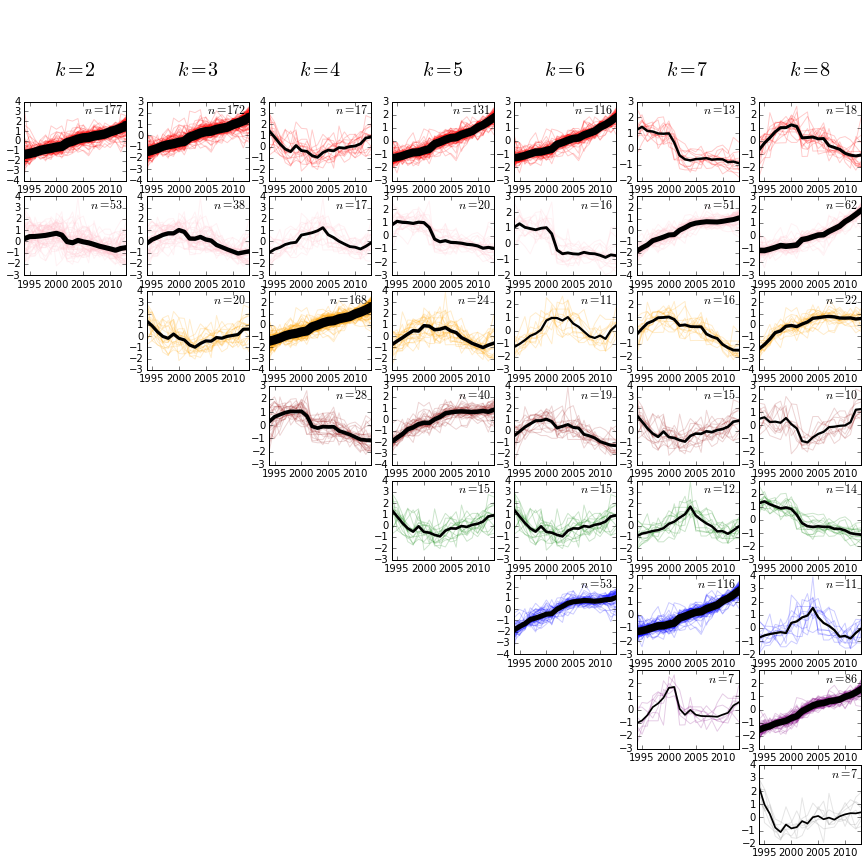

In [32]:
nycest_kmeans_labels = plotMultiCluster(nycbiz_est)

## 5. Mapping by cluster

In [33]:
def clusterlabelmap(geometry, labels, column='k2', alpha=0.5, colormap='brg', annotation=None):
    themap = geometry.join(labels)
    ax = pl.figure(figsize=(15,15))
    themap.dropna().plot(column=column, alpha=alpha, colormap=colormap)
    if annotation is not None:
        ax.text(.15,.8,annotation, size=20, transform=ax)
    #zshape[np.isnan(zshape.k2)].plot()

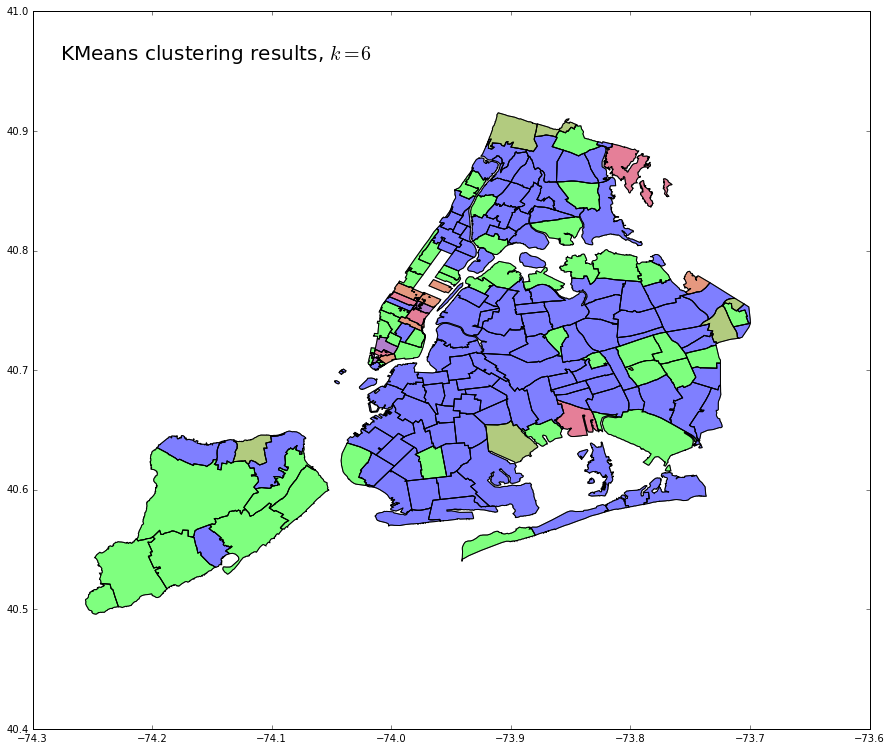

In [34]:
clusterlabelmap(zipshapes, nycest_kmeans_labels, 'k6', annotation='KMeans clustering results, $k=6$')

## 4. Using other methods (Spectral and Ward) 

Creating families of 2 to 8 clusters using spectral...
k = 2 3 4 5 6 7 8 
Plotting clusters...
k = 2 3 4 5 6 7 8


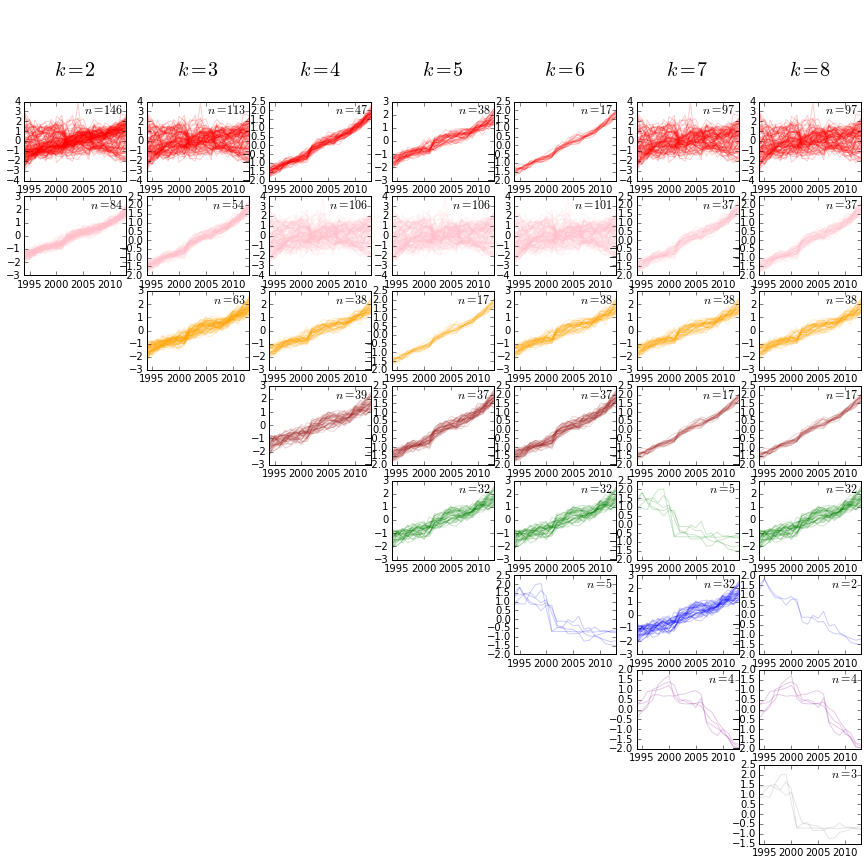

In [35]:
nycest_spectral_labels = plotMultiCluster(nycbiz_est, 'spectral')

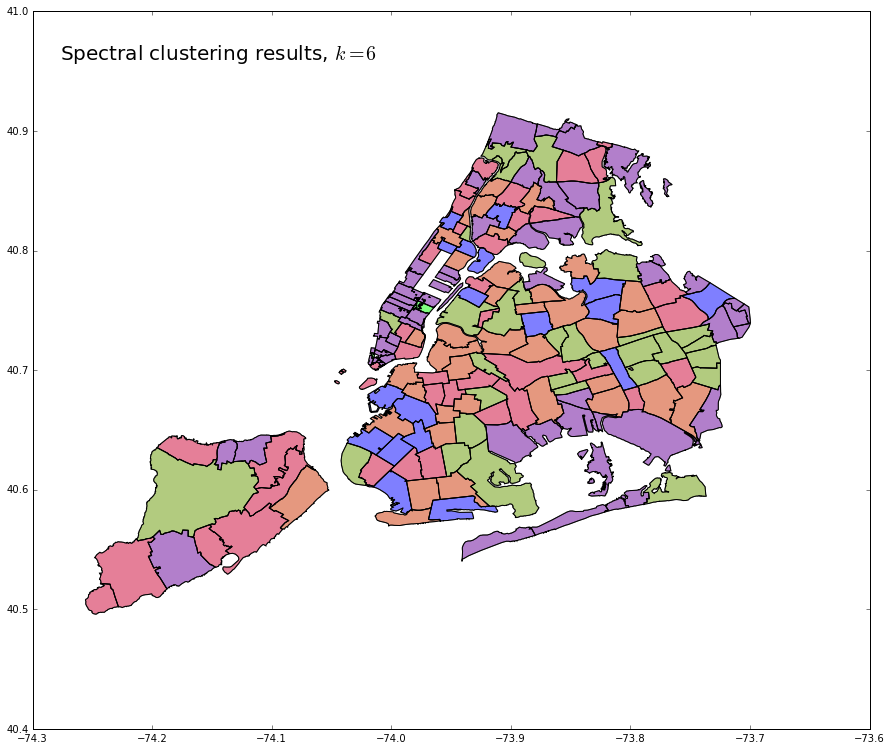

In [36]:
clusterlabelmap(zipshapes, nycest_spectral_labels, 'k6', annotation='Spectral clustering results, $k=6$')


Creating families of 2 to 8 clusters using ward...
k = 2 3 4 5 6 7 8 
Plotting clusters...
k = 2 3 4 5 6 7 8


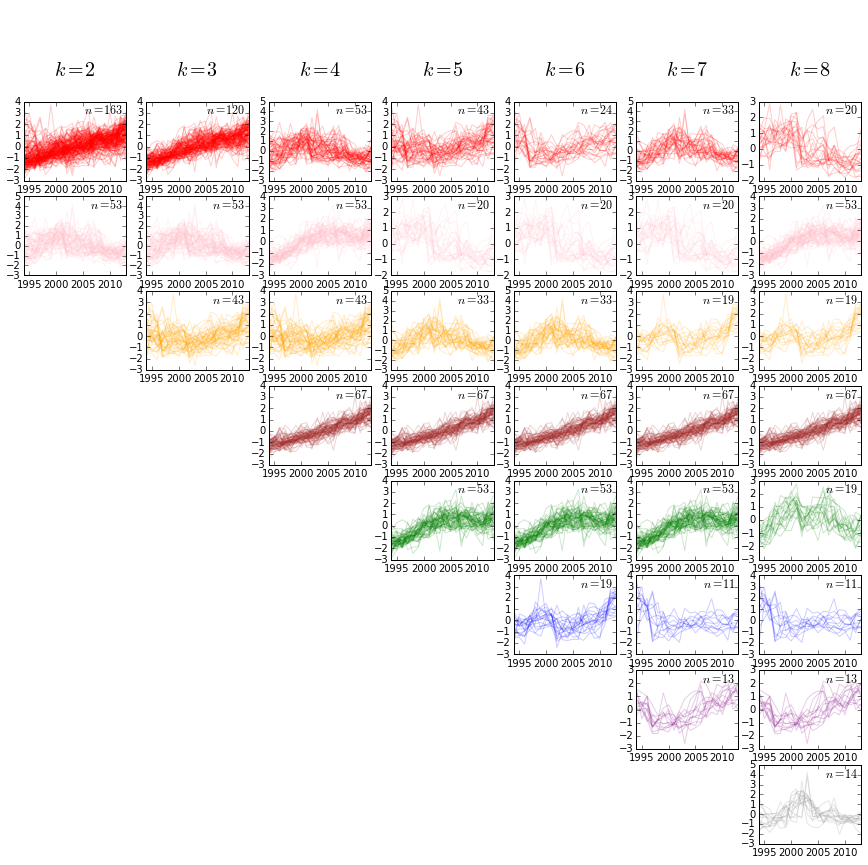

In [37]:
nycemp_ward_labels = plotMultiCluster(nycbiz_emp, 'ward')

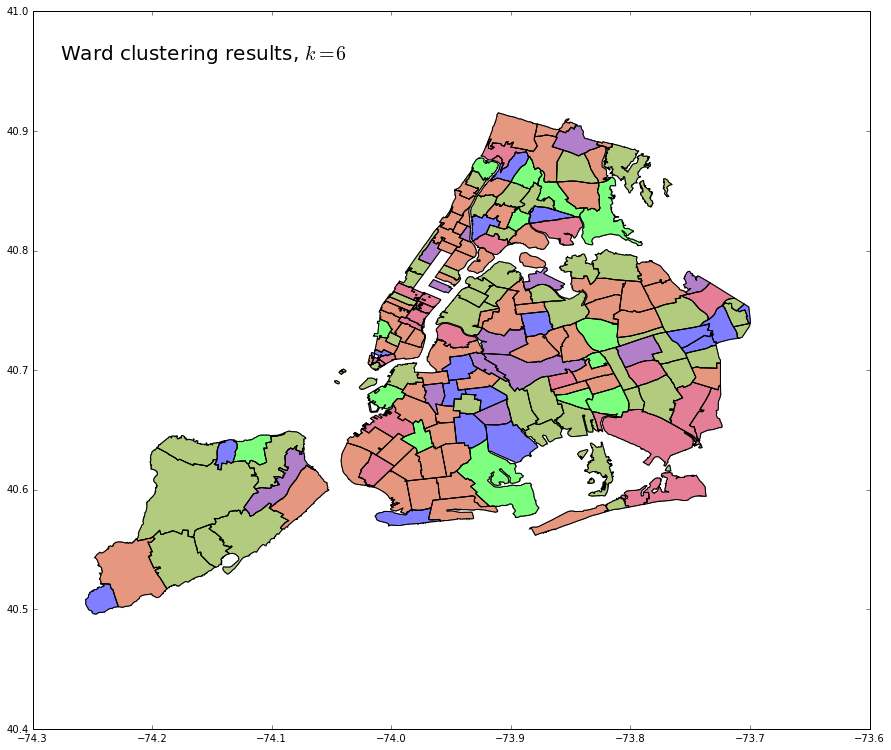

In [38]:
clusterlabelmap(zipshapes, nycemp_ward_labels, 'k6', annotation='Ward clustering results, $k=6$')

## 6. Comparison of methods

KMeans and Ward clustering produce broadly similar results and find a large population of quasi-linearly increasing time series. At $k=6$ KMeans has identified a number of distinct centers that may have a meaningful interpretation (below); other reasonable explainations can probably be made for $k<6$. Spectral clustering produces much different results; its distance measure seems to find differences among the increasing series, but these differences are not discernible by eye (at least not mine).

## 7. Interpretation

From the $k=6$ column of KMeans clusters, we attempt to interpret each of the clusters from top to bottom:

$n=116$: This forms the bulk of the data; these areas are undergoing consistent growth.

$n=16$: This cluster shows areas that have a "new normal" following a negative impact around 2001. Since many of these appear to be in Manhattan, we might posit that this is related to 9/11.

$n=13$: These areas appear to have been negatively impacted by the recession or mortgage crisis, having declined through the 2000's but growing afterwards.

$n=19$: These areas are in decline.

$n=14$: Areas that declined in the '90's but that are in a period of growth.

$n=53$: This cluster seems to reflect an area that had been growing but has started to saturate. 